In [1]:
%matplotlib ipympl
import numpy as np
from pathlib import Path
import utils as utils
import harp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import aeon.io.video as video
from ipywidgets import widgets
from IPython.display import display
import re
import os
import zoneinfo
from datetime import datetime, timezone
import datetime
import matplotlib.pyplot as plt

In [4]:
root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-37_date-20250514/behav/2025-05-14T13-54-46')

In [5]:
metadata_reader = utils.SessionData()
session_settings = utils.load_json(metadata_reader, root/"SessionSettings")
print(session_settings.iloc[0]['metadata'].sequences)

/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-37_date-20250514/behav/2025-05-14T13-54-46/SessionSettings/SessionSettings_*.jsonl
[[{'rewardConditions': [{'definition': [[{'command': 'OdorA', 'rewarded': True}]], 'position': 0}], 'presentationTime': 1.0, 'interCommand': 'Purge', 'interCommandTime': 0.2, 'minimumEngagementTime': 0.25, 'completionRequiresEngagement': True, 'skipSampling': False, 'enableTrialIndicator': True, 'enableRewardLocationIndicator': False, 'rewardAttempts': 0, 'responseTime': 99999.0, 'interTrialInterval': 0.0, 'name': 'OdourDiscriminationA_Stage7', 'defaultCommand': 'Default', 'maximumTime': 10.0, 'resetOnReward': True}, {'rewardConditions': [{'definition': [[{'command': 'OdorB', 'rewarded': True}]], 'position': 1}], 'presentationTime': 1.0, 'interCommand': 'Purge', 'interCommandTime': 0.2, 'minimumEngagementTime': 0.25, 'completionRequiresEngagement': True, 'skipSampling': False, 'enableTrialIndicator': True, 'enableRewardLocationIndicator': False, 'rewardA

In [6]:
# Load relevant data streams
behavior_reader = harp.create_reader('device_schemas/behavior.yml', epoch=harp.REFERENCE_EPOCH)
olfactometer_reader = harp.create_reader('device_schemas/olfactometer.yml', epoch=harp.REFERENCE_EPOCH)
video_reader = utils.Video()
video_data = utils.load_video(video_reader, root/"VideoData")

digital_input_data = utils.load(behavior_reader.DigitalInputState, root/"Behavior")
output_set = utils.load(behavior_reader.OutputSet, root/"Behavior")
output_clear = utils.load(behavior_reader.OutputClear, root/"Behavior")
olfactometer_valves_0 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer0")
olfactometer_valves_1 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer1")
olfactometer_end_0 = utils.load(olfactometer_reader.EndValveState, root/"Olfactometer0")
analog_data = utils.load(behavior_reader.AnalogData, root/"Behavior")
flow_meter = utils.load(olfactometer_reader.Flowmeter, root/"Olfactometer0")
heartbeat = utils.load(behavior_reader.TimestampSeconds, root/"Behavior")

# 'other' events
pulse_supply_1 = utils.load(behavior_reader.PulseSupplyPort1, root/"Behavior")
pulse_supply_2 = utils.load(behavior_reader.PulseSupplyPort2, root/"Behavior")

In [ ]:
## Convert time from hardware to real time

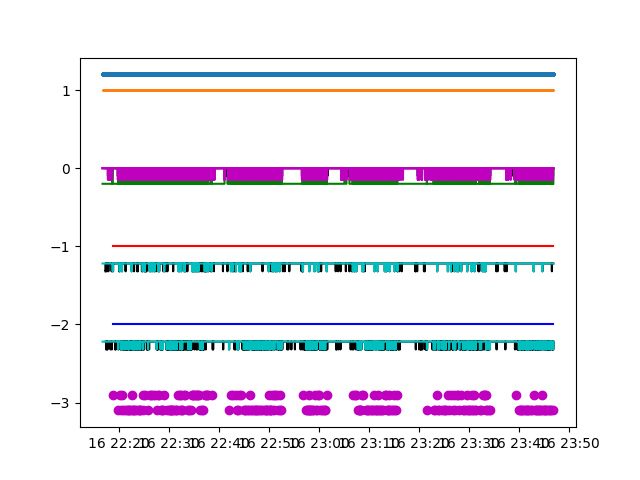

In [7]:
## Plot events of interest for debugging

# find initiation onsets, reward pokes
initiating_events = digital_input_data['DIPort0'][digital_input_data['DIPort0'] == True]
odour_led = utils.concat_digi_events(output_clear['DOPort0'], output_set['DOPort0'])
r1_led = utils.concat_digi_events(output_clear['DOPort1'], output_set['DOPort1'])
r2_led = utils.concat_digi_events(output_clear['DOPort2'], output_set['DOPort2'])

plt.figure()

# plot odour pokes events
plt.step(odour_led.index, odour_led * -0.2, where='post', c='g') # odour port LED
plt.step(digital_input_data.index, digital_input_data['DIPort0'] * -0.1, where='post', c='k') # odour port pokes

# plot odour valve events
plt.step(olfactometer_valves_0.index, olfactometer_valves_0 * -0.15, where='post', c='m') # olfactometer 1 valve events

# plot lick port A events
plt.step(r1_led.index, r1_led * 0.6 - 1, where='post', c='r') # lick port A LED
plt.step(digital_input_data.index, digital_input_data['DIPort1'] * -0.1 - 1.22, where='post', c='k') # lick port A pokes
plt.step(output_set.index, output_set["SupplyPort1"] * -0.1 - 1.22, where='post', c='c') # rewards for lick port A

# plot lick port B events
plt.step(r2_led.index, r2_led * 0.6 - 2, where='post', c='b') # lick port B LED
plt.step(digital_input_data.index, digital_input_data['DIPort2'] * -0.1 - 2.22, where='post', c='k') # lick port B pokes 
plt.step(output_set.index, output_set["SupplyPort2"] * -0.1 - 2.22, where='post', c='c') # rewards for lick port B

plt.scatter(video_data.index, np.ones((len(video_data.index), 1)) + 0.2, s=2.5)
plt.scatter(heartbeat.index, np.ones((len(heartbeat.index), 1)), s=0.1)
#plt.plot(analog_data.index, analog_data['AnalogInput0'] * 0.1)

# other events that may be useful to look at
plt.scatter(pulse_supply_1.index, np.ones((len(pulse_supply_1.index), 1)) - 3.9, c='m')
plt.scatter(pulse_supply_2.index, np.ones((len(pulse_supply_2.index), 1)) - 4.1, c='m')
